In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cobra.io import load_yaml_model
from scipy.stats import fisher_exact
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

Here we use metabolite levels measured from brain samples of ROSMAP to validate reaction activity inferred by iMAP from ROSMAP transcriptomic data.



# Loading data
## Human-GEM
Load Human-GEM using the `COBRApy` package

In [2]:
gempath = '../../resources/human-GEM/v1.11.0/model/Human-GEM.yml'
gem = load_yaml_model(gempath)

## Human-GEM metabolites: from HMDB IDs to replacement IDs
Warning: the code below is useless because the HMDB IDs are not compatible between data sets
Map HMDB IDs to Human-GEM metabolite IDs (`rid`s, i.e replacement IDs)

## Human-GEM metabolites: from KEGG IDs to replacement IDs¶

Each metabolite's KEGG ID (like C00001) is mapped to one or more metabolite replacement IDs (e.g MAM02040c, MAM02040g, MAM02040l,...) corresponding to different cellular **compartments** of the same metabolite.

In [3]:
gempath_xlsx = '../../resources/human-GEM/from-Busra/model/Human-GEM.xlsx'
gem_mets = pd.read_excel(gempath_xlsx, "METS")
s = gem_mets.MIRIAM.apply(lambda ids: re.sub('^.*kegg\.compound/(C[0-9]*).*$', '\\1', ids))
gem_mets['KEGG'] = s.apply(lambda s: None if not re.match('^C', s) else s)
gem_mets = gem_mets.dropna(subset='KEGG')
kegg2rid = gem_mets.groupby('KEGG').apply(lambda x: x['REPLACEMENT ID'].to_list())
kegg2rid

KEGG
C00001    [MAM02040c, MAM02040g, MAM02040l, MAM02040m, M...
C00002    [MAM01371c, MAM01371g, MAM01371l, MAM01371m, M...
C00003    [MAM02552c, MAM02552m, MAM02552n, MAM02552x, M...
C00004    [MAM02553c, MAM02553m, MAM02553x, MAM02553r, M...
C00005    [MAM02555c, MAM02555l, MAM02555m, MAM02555n, M...
                                ...                        
C19607                                          [MAM03038c]
C19691                                          [MAM01805c]
C19848                                          [MAM01281c]
C19910         [MAM02543c, MAM02543l, MAM02543n, MAM02543e]
C20120                                          [MAM02898c]
Length: 1565, dtype: object

## Aggregation of iMAT results

Below is a tree connecting a metabolite to all reactions in Human-GEM that the metabolite is involved in.

`
metabolite (KEGG ID) --- metabolite/compartment 1 --- reaction set 1: { rxn 1.1, rxn 1.2,...}
                     |
                     |-- metabolite/compartment 2 --- reaction set 2: { rxn 2.1, rxn 2.2,...}
                     |
                    ...
                     |
                     |-- metabolite/compartment k --- reaction set k: { rxn k.1, rxn k.2,...}
`

The iMAT based results must be aggregated for every given metabolite.  The code below does this by implementing
$$
\begin{equation}
p_\mathrm{met} = \min \{p_{1.1}, p_{1.2},..., p_{2.1}, p_{2.2},..., p_{k.1}, p_{k.2},...\}
\end{equation}
$$
where $p_\mathrm{met}$ is the p-value associated to the metabolite and $p_{i.j}$ is the $j$th reaction the metabolite participates in the $i$th compartment.  Thus, we defined $p_\mathrm{met}$ as the minimum of all associated p-values.

In [4]:
def get_rxn_ids(rid, gem=gem):
    '''Get all reactions in GEM involving metabolite rid'''
    met = gem.metabolites.get_by_id(rid)
    rxn_ids = [r.id for r in met.reactions]
    return(rxn_ids)

def aggregate1met(keggid, imat, kegg2rid=kegg2rid, gem=gem):
    '''Aggregates IMAT p-values across all reactions involving metabolite keggid'''
    l = [imat.loc[get_rxn_ids(rid, gem=gem), 'p_value'].min() for rid in kegg2rid.loc[keggid]]
    pval = np.min(l)
    return(pval)

## Mapping between CHEM IDs and KEGG IDs

In [5]:
fpath = '../../resources/tunahan/ROSMAP-metabolomics/ROSMAP-Metabolon-HD4-Data-Dictionary.xlsx'
rosmap_dict = pd.read_excel(fpath, index_col='CHEM_ID')
rosmap_dict

,LIB_ID,COMP_ID,CHRO_LIB_ENTRY_ID,SUPER_PATHWAY,SUB_PATHWAY,PATHWAY_SORTORDER,PATHWAY_STATUS,TYPE,INCHIKEY,SMILES,CHEMICAL_NAME,SHORT_NAME,CAS,CHEMSPIDER,HMDB,KEGG,PLANT_CYC,PUBCHEM,PLATFORM
CHEM_ID,,,,,,,,,,,,,,,,,,,
35,400,42370,166164,Amino Acid,Glutamate Metabolism,62.0,NaN,NAMED,DWAKNKKXGALPNW-REWHXWOFAV,OC(C1CCC=N1)=O,S-1-pyrroline-5-carboxylate,S-1-pyrroline-5-carboxylate,2906-39-0,10140206.0,HMDB0001301,C04322,NaN,1.196618e+07,LC/MS Pos Early
41,400,1633,155434,Amino Acid,Histidine Metabolism,85.0,NaN,NAMED,CCLQKVKJOGVQLU-QMMMGPOBBT,NCCCC(NC(CC1=CN=CN1)C(O)=O)=O,homocarnosine,homocarnosine,3650-73-5,8418848.0,HMDB0000745,C00884,NaN,8.923510e+12,LC/MS Pos Early
49,400,1408,155357,Amino Acid,Polyamine Metabolism,537.0,NaN,NAMED,KIDHWZJUCRJVML-UHFFFAOYAX,NCCCCN,putrescine,putrescine,110-60-1,13837702.0,HMDB0001414,C00134,PUTRESCINE,1.045000e+03,LC/MS Pos Early
50,400,485,155305,Amino Acid,Polyamine Metabolism,545.0,NaN,NAMED,ATHGHQPFGPMSJY-UHFFFAOYAK,NCCCCNCCCN,spermidine,spermidine,124-20-9,1071.0,HMDB0001257,C00315,SPERMIDINE,1.102000e+03,LC/MS Pos Early
55,400,27665,155829,Cofactors and Vitamins,Nicotinate and Nicotinamide Metabolism,4314.0,NaN,NAMED,LDHMAVIPBRSVRG-UHFFFAOYAE,C[N+]1=CC(C([NH-])=O)=CC=C1,1-methylnicotinamide,1-methylnicotinamide,1005-24-9,8305504.0,HMDB0000699,C02918,NaN,4.570000e+02,LC/MS Pos Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999925957,400,63908,223734,NaN,NaN,NaN,NaN,UNNAMED,NaN,NaN,X - 25957,X - 25957,NaN,NaN,NaN,NaN,NaN,NaN,LC/MS Pos Early
999925981,400,63971,224188,NaN,NaN,NaN,NaN,UNNAMED,NaN,NaN,X - 25981,X - 25981,NaN,NaN,NaN,NaN,NaN,NaN,LC/MS Pos Early
999925982,400,63972,224189,NaN,NaN,NaN,NaN,UNNAMED,NaN,NaN,X - 25982,X - 25982,NaN,NaN,NaN,NaN,NaN,NaN,LC/MS Pos Early


# Analysis
## Align Met and iMAT data using KEGG IDs

In [6]:
def pick1kegg(kegglist, kegg2rid=kegg2rid):
    '''Pick the right KEGG ID from a set'''
    keggidl = [x for x in kegglist if x in kegg2rid.index]
    if len(kegglist) == 0 or len(keggidl) == 0:
        return(None)
    keggid = keggidl[0]
    return(keggid)


def align_data(subtype='A', rosmap_dict=rosmap_dict):
    '''Align Met(abolite profiling) data with iMAT data'''
    insert = '' if subtype == 'no-subtyping' else '-' + subtype
    imat_path = '../../results/2023-02-06-AD-subtypes-active-reactions/fisher-exact-r-AD' + insert + '_wrt_r-control.csv'
    imat = pd.read_csv(imat_path, index_col='rxn_ID')
    sheet_name = 'Class' + subtype if subtype in {'A', 'B'} else 'Subtype' + subtype
    sheet_name = subtype if subtype == 'no-subtyping' else sheet_name
    fpath = '../../resources/tunahan/ROSMAP-metabolomics/metabolome-results-all.xlsx'
    data = pd.read_excel(fpath, sheet_name=sheet_name, index_col='CHEM_ID')
    data['KEGG'] = rosmap_dict.loc[data.index, 'KEGG']
    data = data.dropna(subset='KEGG')
    data['KEGG'] = data.KEGG.str.split(',').apply(lambda l: pick1kegg(l)).dropna()
    data = data.dropna(subset='KEGG')
    data['CHEM_ID'] = data.index
    data.index = data.KEGG
    data['iMAT pval'] = data.KEGG.apply(lambda keggid: aggregate1met(keggid, imat))
    data = data.rename({'pval': 'Met pval'}, axis=1)
    return(data)


def my_fisher(data, alpha=0.05, xtab=False):
    data['Met change'] = data['Met pval'].apply(lambda p: 1 if p < alpha else 0)
    data['iMAT change'] = data['iMAT pval'].apply(lambda p: 1 if p < alpha else 0)
    crosstab = pd.crosstab(data['Met change'], data['iMAT change'])
    if xtab:
        return(crosstab)
    statistic, pvalue = fisher_exact(crosstab)
    return(pvalue)


## Metabolites in data sets

In [7]:
fpath = '../../resources/tunahan/ROSMAP-metabolomics/metabolome-results-all.xlsx'
data = pd.read_excel(fpath, sheet_name='ClassA', index_col='CHEM_ID')
data0 = data.copy()
data['KEGG'] = rosmap_dict.loc[data.index, 'KEGG']
data = data.dropna(subset='KEGG')
data1 = data.copy()
data['KEGG'] = data.KEGG.str.split(',').apply(lambda l: pick1kegg(l)).dropna()
data2 = data.copy()
data = data.dropna(subset='KEGG')

In [8]:
n_met = {
    'metabolite-compartment pairs in Human-GEM': len(gem.metabolites), # metabolite-compartment pairs in Human-GEM
    'metabolites in Human-GEM': np.unique([m.id[:-1] for m in gem.metabolites]).shape[0], # metabolites in Human-GEM
    'metabolites in Human-GEM; with KEGG ID': kegg2rid.shape[0], # metabolites in Human-GEM with KEGG ID
    'metabolites both in Human-GEM and measured; with KEGG ID': align_data('A').shape[0], # metabolites in both Human-GEM and Met. profiling with KEGG ID
    'metabolites measured; with KEGG ID': data2.shape[0], # metabolites in Met. profiling with KEGG ID
    'metabolites measured': data0.shape[0], # metabolites in Met. profiling
}
n_met = pd.Series(n_met.values(), n_met.keys())
n_met

metabolite-compartment pairs in Human-GEM                   8366
metabolites in Human-GEM                                    4112
metabolites in Human-GEM; with KEGG ID                      1565
metabolites both in Human-GEM and measured; with KEGG ID     200
metabolites measured; with KEGG ID                           301
metabolites measured                                         686
dtype: int64

<Axes: >

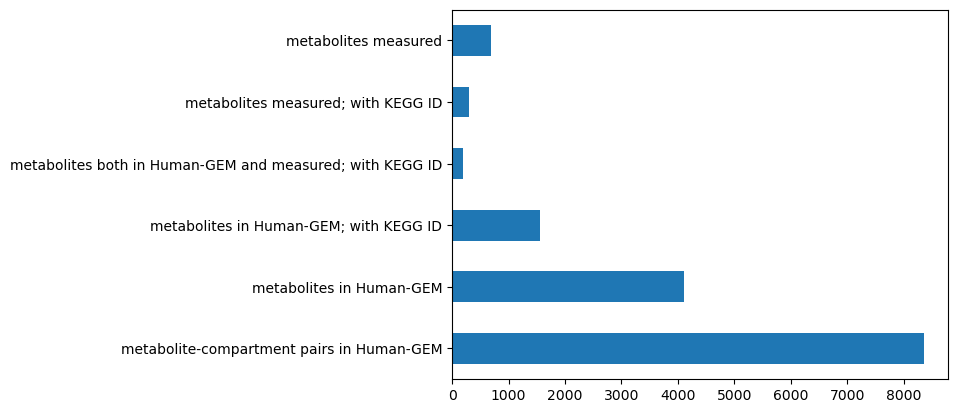

In [9]:
n_met.plot(kind='barh')

## Validation using Fisher's exact test

Below are p-values for Fisher's exact test for independence of AD-affected metabolites from AD-affected iMAT-based reactions.  The p-values suggest independence, which means unsuccessful validation.

In [10]:
d = {subtype: my_fisher(align_data(subtype), xtab=False) for subtype in ['no-subtyping', 'A', 'B', 'C1', 'C2']}
validation = pd.DataFrame(d, index=['alpha=0.05'])
validation

,no-subtyping,A,B,C1,C2
alpha=0.05,0.244794,0.272871,0.177242,1.0,0.313777


In [11]:
d = {subtype: my_fisher(align_data(subtype), xtab=True) for subtype in ['no-subtyping', 'A', 'B', 'C1', 'C2']}
for subtype in d.keys():
    print(subtype)
    print(d[subtype])
    print('\n')

no-subtyping
iMAT change    0   1
Met change          
0            113  80
1              6   1


A
iMAT change   0   1
Met change         
0            88  98
1             9   5


B
iMAT change   0    1
Met change          
0            84  101
1            10    5


C1
iMAT change   0   1
Met change         
0            97  94
1             5   4


C2
iMAT change   0    1
Met change          
0            82  114
1             3    1




In [12]:
%connect_info

{
  "shell_port": 52056,
  "iopub_port": 52057,
  "stdin_port": 52058,
  "control_port": 52060,
  "hb_port": 52059,
  "ip": "127.0.0.1",
  "key": "0beafbc0-8710f1ece55756feef98aef7",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d67268c3-20a8-4fdc-bfd5-159e388fa8af.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
